In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import PyLyrics as lyrics
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from time import time, sleep
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
# import sys
# sys.version

In [17]:
with open('../data/creds.json', 'r') as f:
    creds = json.load(f)
    client_id = creds["id"]
    client_secret = creds["secret"]

spotify_green = '#1db954'
spotify_black = '#191414'

In [18]:
class Dataset:
    def __init__(self, client_id, client_secret):
        client_cred = SpotifyClientCredentials(client_id=client_id,
                                                      client_secret=client_secret)
        self.sp = spotipy.Spotify(client_credentials_manager=client_cred)
        self.data_dict = {'__disclaimer': "I do not own any of the data included here, and intend to use this for academic purposes only.", 
                          'tracks':  {},
                          'users':   {},
                          'albums':  {},
                          'artists': {}
                          }

    def size(self):
        return len(self.data_dict['tracks'])
    
    def num_users(self):
        return len(self.data_dict['users'])
                        
    def load_data(self, data_filepath):
        with open(data_filepath, 'r') as f:
            self.data_dict = json.load(f)

    def save_data(self, data_filepath):
        with open(data_filepath, 'w') as f:
            json.dump(self.data_dict, f)

    def fetch_user_data(self, user_id, get_artist_tracks=False):
        user_playlists = self.sp.user_playlists(user_id)
        for playlist in user_playlists['items']:
            if playlist['owner']['id'] == user_id:
                print(playlist['name'], end='')
                print(' -- ', playlist['tracks']['total'])
                results = self.sp.user_playlist(user_id, playlist['id'], fields='tracks,next')
                tracks = results['tracks']
                for i, item in enumerate(tracks['items']):
                    track = item['track']
                    # pprint(track)
                    self.add_data(user_id, track)
                while tracks['next']:
                    tracks = self.sp.next(tracks)
                    for i, item in enumerate(tracks['items']):
                        track = item['track']
                        # pprint(track)
                        self.add_data(user_id, track)
        user_tracks = self.data_dict['users'][user_id]['tracks']
        self.data_dict['users'][user_id]['tracks'] = list(set(user_tracks))

    def add_data(self, user_id, track_obj):
        track_name = track_obj['name']
        track_id = track_obj['id']
        if user_id in self.data_dict['users']:
            self.data_dict['users'][user_id]['tracks'].append(track_id)
        else:
            self.data_dict['users'][user_id] = {'tracks' : [track_id], 'artists':{}}
        artist_id = track_obj['artists'][0]['id']
        artist = track_obj['artists'][0]['name']
        if len(artist)==0: 
            return
        if artist_id in self.data_dict['artists']:
            pass
        else:
            self.data_dict['artists'][artist_id] = artist
                                                    
        if track_id in self.data_dict['tracks']:
            # print("track info already present:", track_name, ":", artist)
            return
        else:
            if len(track_name) == 0: 
                return
            track_data = self.get_feats(artist, track_obj)
            track_data['artist_id'] = artist_id
            
            # update artist info only for new tracks 
            if artist_id in self.data_dict['users'][user_id]['artists']:
                self.data_dict['users'][user_id]['artists'][artist_id] += 1
            else:
                self.data_dict['users'][user_id]['artists'][artist_id] = 1

            self.data_dict['tracks'][track_id] = track_data
        
    def get_feats(self, artist, track):
        track_id = track['id']
        track_name = track['name'].strip()
        artist_id = track['artists'][0]['id']
        album_name = track['album']['name'].strip()
        track_duration = track['duration_ms']/1000
        track_audio_feats = self.sp.audio_features(track_id)[0]
        track_popularity = track['popularity']
        album_id = track['album']['id']
        if album_id in self.data_dict['albums']:
            # print("Album info already present: ", album_name, "-", artist)
            album_info = self.data_dict['albums'][album_id]
        else:
            album_data = self.sp.album(album_id)
            album_info = {'name': album_name,
                          'release_year': album_data['release_date'][:4],
                          'popularity': album_data['popularity']/100,
                          'album_art': [i['url'] for i in track['album']['images']][0],
                          'genres': album_data['genres'],
                          'artist': artist,
                          'artist_id': artist_id}
            self.data_dict['albums'][album_id] = album_info
        release_year = album_info['release_year']
        genres = album_info['genres']
        
        for i in ['uri', 'id', 'analysis_url', 'track_href', 'type', 'duration_ms']:
            del track_audio_feats[i]
        track_lyrics = 'N/A'
        try:
            track_lyrics = lyrics.PyLyrics.getLyrics(artist, track_name)
        except ValueError as e:
            track_name = track_name.split('-')[0].strip()
            try:
                track_lyrics = lyrics.PyLyrics.getLyrics(artist, track_name)
            except ValueError as e:
                print('Lyrics not found for %s - %s'%(artist, track_name))
        track_data = {'name': track_name, 
                      'artist': artist,
                      'album': album_name,
                      'album_id': album_id,
                      'popularity': track_popularity/100,
                      'release_year': release_year,
                      'genres': genres,
                      'duration': track_duration, 
                      'lyrics': track_lyrics, 
                      }
        for k, v in track_audio_feats.items():
            track_data[k] = v
        return track_data

In [19]:
dataset = Dataset(client_id, client_secret)
dataset.load_data('../data/spotify_data.json')

In [20]:
tic = time()
for user in ['ajinkyaz']:
    print("User:", user)
    dataset.fetch_user_data(user)
    print("")
print('Took ', time()-tic, 'seconds')

User: ajinkyaz
Random Shite --  147
Schoolboy --  88
Git off my lawn! --  125
Soundtrack Music --  49

Took  4.263526201248169 seconds


In [21]:
print('Total tracks --', dataset.size())
print('Total users --', dataset.num_users())

Total tracks -- 385
Total users -- 1


In [22]:
def top_artists(user_id, n=20):
    artists = sorted(list(dataset.data_dict['users'][user_id]['artists'].items()),
                     key=lambda x: -x[1])
    #print(len(set([i[0] for i in artists])))
    if n == -1:
        return artists
    else:
        artists = [(dataset.data_dict['artists'][i[0]], i[1]) for i in artists[:n]]
    return artists

for user in dataset.data_dict['users']:
    print(user)
    x = set([i[0] for i in top_artists(user, -1)])
    for user2 in dataset.data_dict['users']:
        if user == user2:
            continue
        y = set([i[0] for i in top_artists(user2, -1)])
        sim = round(2*len(x.intersection(y))/(len(x)+len(y)), 2) # sorensen-dice coeff
        sim2 = round(len(x.intersection(y))/(len(x.union(y))), 2) # jaccard sim
        print("Artist similarity score for %s and %s : %s (dice) OR %s (jaccard)"%(user, user2, sim, sim2))
    print("")

for user in dataset.data_dict['users']:
    pprint(top_artists(user, 10))
    print(" ")

ajinkyaz

[('Linkin Park', 10),
 ('Iron Maiden', 7),
 ('Coldplay', 7),
 ('Eminem', 7),
 ('John Williams', 6),
 ('Skillet', 6),
 ('Michael Jackson', 5),
 ('Alexandre Desplat', 5),
 ('Backstreet Boys', 5),
 ('David Bowie', 5)]
 


55.6 percent of ajinkyaz's tracks are positive


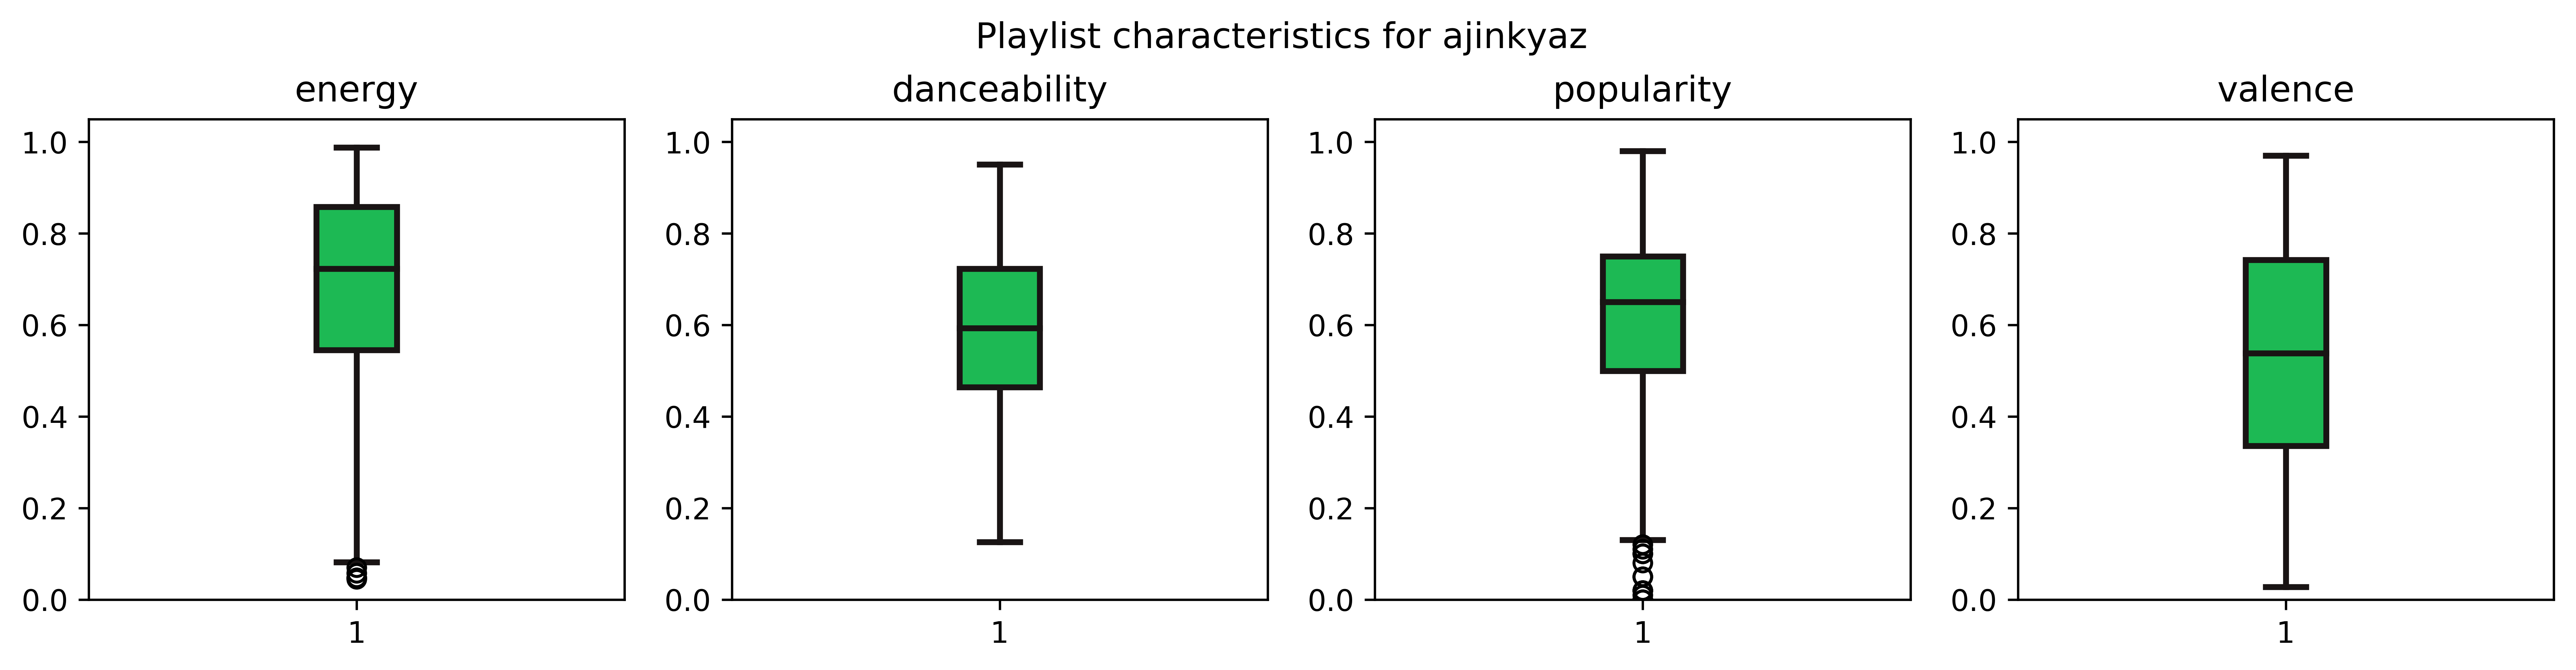

In [23]:
user_stats = {}
for user in dataset.data_dict['users']:
    user_tracks = dataset.data_dict['users'][user]['tracks']
    user_stats[user] = {'valence': [], 'popularity': [], 'energy': [], 'danceability': []}
    for i in list(set(user_tracks)):
        if i not in dataset.data_dict['tracks']: continue
        val_track = dataset.data_dict['tracks'][i]['valence']
        pop_track = dataset.data_dict['tracks'][i]['popularity']
        dance_track = dataset.data_dict['tracks'][i]['danceability']
        energy_track = dataset.data_dict['tracks'][i]['energy']
        user_stats[user]['valence'].append(val_track)
        user_stats[user]['popularity'].append(pop_track)
        user_stats[user]['danceability'].append(dance_track)
        user_stats[user]['energy'].append(energy_track)
    ax = {}
    fig = plt.figure(figsize=(15, 3), dpi=600)
    plt.suptitle('Playlist characteristics for %s'%user, verticalalignment='bottom')

    for k, v in user_stats[user].items():
        v = np.array(v)
        # print(len(v))
        num = 140+len(ax)+1 # 1 row, 4 cols, pos
        if k == 'valence':
            pos_tracks = v[v>0.5]
            percent_pos = round((pos_tracks.shape[0]/v.shape[0])*100, 1)
            print("%s percent of %s's tracks are positive"%(percent_pos, user))
        ax[k] = fig.add_subplot(num)
        ax[k].set_ylim([0.0, 1.05])
        ax[k].title.set_text(k)
        
        #styling
        bp = ax[k].boxplot(v, patch_artist=True)
        for box in bp['boxes']:
            box.set_edgecolor(spotify_black)
            box.set_facecolor(spotify_green)
            box.set_linewidth(2)
        for med in bp['medians']:
            med.set_linewidth(2)
            med.set_color(spotify_black)
        for whisker in bp['whiskers']:
            whisker.set_linewidth(2)
            whisker.set_color(spotify_black)
        for cap in bp['caps']:
            cap.set_linewidth(2)
            cap.set_color(spotify_black)
    plt.show()

In [24]:
#client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
#sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [25]:
#scope = 'user-library-read'
#token = util.prompt_for_user_token('ajinkyaz', scope=scope, client_id=client_id, client_secret=client_secret, redirect_uri='http://localhost:8888/notebooks/notebooks/NB1.ipynb')

In [26]:
df1 = pd.read_json('../data/just_tracks.json').T

In [27]:
view_num = df1[['name', 'artist', 'release_year', 'duration', 'popularity', 'valence', 'energy', 'acousticness', 'danceability']]

In [28]:
view_num

,name,artist,release_year,duration,popularity,valence,energy,acousticness,danceability
00QyLmjxaSEE8qIZQjBXBj,We Own It (Fast & Furious),2 Chainz,2013,227.893,0.67,0.557,0.897,0.0596,0.553
0385HqYimoTQaHZP17KwG1,We Found Love,Calvin Harris,2012,215.52,0.21,0.608,0.776,0.0234,0.738
04KsMCb9PZE2S0AtUU8Jhb,April Showers,Proleter,2011,275.751,0.58,0.902,0.546,0.28,0.801
04YSVJjUnZED8YNXlQR1fk,White Christmas,Irving Berlin,1990,160.013,0.52,0.443,0.0909,0.927,0.506
06dT0EYXrhRQV1MsvWhNGv,Bad (feat. Vassy),David Guetta,2014,170.625,0.55,0.411,0.972,0.00125,0.614
08mG3Y1vljYA6bvDt4Wqkj,Back In Black,AC/DC,1980,255.493,0.84,0.763,0.7,0.011,0.31
0BB9eUBBaaX6GALSYNcEp7,You Spin Me Round (Like a Record),Dead Or Alive,1985,196.8,0.72,0.96,0.851,0.006,0.554
0C80GCp0mMuBzLf3EAXqxv,Shoot to Thrill,AC/DC,1980,317.426,0.71,0.48,0.904,0.000239,0.457
0DFRrABd2ppHhS3QaZuCJ1,Fuck Tha Police,N.W.A.,1996,343.373,0.62,0.737,0.837,0.00956,0.85
0EYOdF5FCkgOJJla8DI2Md,B.Y.O.B.,System Of A Down,2005,255.466,0.78,0.716,0.981,0.00662,0.556
